## mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, shutil
path = "/content/drive/My Drive/DL_project"
os.chdir(path)
os.listdir(path)

['slides',
 'patches_and_labels_sm',
 'patches_and_labels',
 'dataset_L2',
 'dataset_L3',
 'dataset_L4',
 'dataset_L5',
 'my_model',
 'patches_and_labels (1)',
 'my_model_dropout_trainable',
 'model_multiple_zoom',
 'my_model_pretrained',
 'my_model_not_pretrained']

# project start


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# tissue_pixels = find_tissue_pixels(slide_image)
# percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
# print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


## Preparations (data)

In [ ]:
# slides split
slides_idx = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057',
              '059', '064', '075','078', '081', '091', '094', '096', '101', '110']

slide_paths = ['slides/tumor_{}.tif'.format(i) for i in slides_idx]
tumor_mask_paths = ['slides/tumor_{}_mask.tif'.format(i) for i in slides_idx]

# 70% train, 15% test, 15 validation

train_slide_paths, test_slide_paths, validation_slide_paths = slide_paths[:14], slide_paths[14:17], slide_paths[17:]
train_tumor_mask_paths = tumor_mask_paths[:14]
test_tumor_mask_paths = tumor_mask_paths[14:17]
validation_tumor_mask_paths = tumor_mask_paths[17:]


In [ ]:
import random

def get_patches_and_labels(slide_path, tumor_mask_path, level=2):
    # save patches of different resolution in different directories.
    name = slide_path.split('/')[-1][:-4]
    main_dir = 'patches_and_labels'
    if not os.path.exists(main_dir):
        os.mkdir(main_dir)
    slide_dir = os.path.join(main_dir, name)
    if not os.path.exists(slide_dir):
        os.mkdir(slide_dir)
    slide_pos_dir = os.path.join(slide_dir, 'positive')
    slide_pos_dir_L2 = os.path.join(slide_pos_dir, 'L2')
    slide_pos_dir_L3 = os.path.join(slide_pos_dir, 'L3')
    slide_pos_dir_L4 = os.path.join(slide_pos_dir, 'L4')
    slide_pos_dir_L5 = os.path.join(slide_pos_dir, 'L5')
    slide_neg_dir = os.path.join(slide_dir, 'negative')
    slide_neg_dir_L2 = os.path.join(slide_neg_dir, 'L2')
    slide_neg_dir_L3 = os.path.join(slide_neg_dir, 'L3')
    slide_neg_dir_L4 = os.path.join(slide_neg_dir, 'L4')
    slide_neg_dir_L5 = os.path.join(slide_neg_dir, 'L5')
    for dir_path in [slide_pos_dir, slide_pos_dir_L2, slide_pos_dir_L3, slide_pos_dir_L4, slide_pos_dir_L5,
                    slide_neg_dir, slide_neg_dir_L2, slide_neg_dir_L3, slide_neg_dir_L4, slide_neg_dir_L5]:
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
    ######
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    # slide a window across the slide
    window_width = 299
    window_height = 299
    stride = 128
    # 
    slide_width, slide_height = slide.level_dimensions[level]
    # num of grids
    nx = (slide_width - window_width) // stride + 1
    ny = (slide_height - window_height) // stride + 1
    print(nx, ny)
    kk = 0
    for i in range(ny):
        for j in range(nx):
            x, y = j * stride, i * stride
            region = read_slide(slide, x=x * 2**level, y = y * 2**level, 
                               level=level, width=window_width, height=window_height)
#             plt.imshow(region)
#             plt.show()
            # find if it contains tissue
            tissue_pixels = find_tissue_pixels(region)
            if len(tissue_pixels) > 299*299/100*2:
                # tissue pixels percentage larger than 2%, this region has tissue
                # get label of this region
                mask_region = read_slide(tumor_mask, x=x * 2**level, y = y * 2**level, 
                               level=level, width=window_width, height=window_height)[:,:,0]
                label = mask_region[86:214, 86:214].max()
                # if label=1, it is positive, else, negative
                
                # prepare zoom out patches, same center
                ############################
                level2 = level + 1
                level3 = level + 2
                level4 = level + 3
#          
                ############################
               
                #
                if label==1: # positive
                    region2 = read_slide(slide, x=(x - window_width//2)* 2**level,
                                    y=(y- window_height//2)*2**level, level=level2,
                                    width=window_width, height=window_height)
                    region3 = read_slide(slide, x=(x - window_width//2*3)* 2**level,
                                    y=(y-window_height//2*3)*2**level, level=level3,
                                    width=window_width, height=window_height)
                    region4 = read_slide(slide, x=(x - window_width//2*7)* 2**level,
                                    y=(y-window_height//2*7)*2**level, level=level4,
                                    width=window_width, height=window_height)
                    region = Image.fromarray(region)
                    region2 = Image.fromarray(region2)
                    region3 = Image.fromarray(region3)
                    region4 = Image.fromarray(region4)
                    region.save(slide_pos_dir_L2 + '/{}.png'.format(kk))
                    region2.save(slide_pos_dir_L3 + '/{}.png'.format(kk))
                    region3.save(slide_pos_dir_L4 + '/{}.png'.format(kk))
                    region4.save(slide_pos_dir_L5 + '/{}.png'.format(kk))
                    kk += 1
                elif label==0:  # negative
                    if random.random() < 0.9:
                        region2 = read_slide(slide, x=(x - window_width//2)* 2**level,
                                    y=(y- window_height//2)*2**level, level=level2,
                                    width=window_width, height=window_height)
                        region3 = read_slide(slide, x=(x - window_width//2*3)* 2**level,
                                    y=(y-window_height//2*3)*2**level, level=level3,
                                    width=window_width, height=window_height)
                        region4 = read_slide(slide, x=(x - window_width//2*7)* 2**level,
                                    y=(y-window_height//2*7)*2**level, level=level4,
                                    width=window_width, height=window_height)
                        region = Image.fromarray(region)
                        region2 = Image.fromarray(region2)
                        region3 = Image.fromarray(region3)
                        region4 = Image.fromarray(region4)
                        region.save(slide_neg_dir_L2 + '/{}.png'.format(kk))
                        region2.save(slide_neg_dir_L3 + '/{}.png'.format(kk))
                        region3.save(slide_neg_dir_L4 + '/{}.png'.format(kk))
                        region4.save(slide_neg_dir_L5 + '/{}.png'.format(kk))
                        kk += 1


                    


                
    
     
    
    

In [ ]:
# get patches and labels from all slides

# for i in range(20):
    # slide_path = slide_paths[i]
    # tumor_mask_path = tumor_mask_paths[i]
    # get_patches_and_labels(slide_path, tumor_mask_path, level=2)

In [ ]:
from random import choices
import shutil

""" In this part, i create a balanced dataset to avoid always predicting negative"""

def create_dataset():
    # create dir
    for i in ['L2', 'L3', 'L4', 'L5']:
        dir_name = 'dataset_{}'.format(i) 
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
            for k in ['train', 'train/positive', 'train/negative',
                     'validation', 'validation/positive', 'validation/negative']:
                os.mkdir(os.path.join(dir_name, k))
    
    train_dir = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', '064', '075', '078']
    validation_dir = ['081', '091', '094']
    # test_dir = ['096', '101', '110'] # these three slides are used for testing, not used here

    train_dir = ['patches_and_labels/tumor_{}'.format(i) for i in train_dir]
    validation_dir = ['patches_and_labels/tumor_{}'.format(i) for i in validation_dir]
    
    kk = 1
    # 
    for i in train_dir + validation_dir:
        pos_path = os.path.join(i, 'positive')
        neg_path = os.path.join(i, 'negative')
        # L2
        pos_L2 = os.path.join(pos_path, 'L2')
        neg_L2 = os.path.join(neg_path, 'L2')
        list_pos_L2 = os.listdir(pos_L2)
        list_pos_L2 = [n for n in list_pos_L2 if n != '.DS_Store']
        list_neg_L2 = os.listdir(neg_L2)
        list_neg_L2 = [n for n in list_neg_L2 if n != '.DS_Store']
        list_neg_L2 = choices(list_neg_L2, k=len(list_pos_L2))
        
        # 
        pos_L3 = os.path.join(pos_path, 'L3')
        neg_L3 = os.path.join(neg_path, 'L3')
        
        pos_L4 = os.path.join(pos_path, 'L4')
        neg_L4 = os.path.join(neg_path, 'L4')
        
        pos_L5 = os.path.join(pos_path, 'L5')
        neg_L5 = os.path.join(neg_path, 'L5')
        for j in range(len(list_pos_L2)):
            pos_name = list_pos_L2[j]
            neg_name = list_neg_L2[j]
            pos_L2_path = os.path.join(pos_L2, pos_name)
            pos_L3_path = os.path.join(pos_L3, pos_name)
            pos_L4_path = os.path.join(pos_L4, pos_name)
            pos_L5_path = os.path.join(pos_L5, pos_name)
            
            neg_L2_path = os.path.join(neg_L2, neg_name)
            neg_L3_path = os.path.join(neg_L3, neg_name)
            neg_L4_path = os.path.join(neg_L4, neg_name)
            neg_L5_path = os.path.join(neg_L5, neg_name)
            # 
            if i in train_dir:
                L2_new_pos_path = 'dataset_L2/train/positive'
                L2_new_neg_path = 'dataset_L2/train/negative'
                L3_new_pos_path = 'dataset_L3/train/positive'
                L3_new_neg_path = 'dataset_L3/train/negative'
                L4_new_pos_path = 'dataset_L4/train/positive'
                L4_new_neg_path = 'dataset_L4/train/negative'
                L5_new_pos_path = 'dataset_L5/train/positive'
                L5_new_neg_path = 'dataset_L5/train/negative'
            elif i in validation_dir:
                L2_new_pos_path = 'dataset_L2/validation/positive'
                L2_new_neg_path = 'dataset_L2/validation/negative'
                L3_new_pos_path = 'dataset_L3/validation/positive'
                L3_new_neg_path = 'dataset_L3/validation/negative'
                L4_new_pos_path = 'dataset_L4/validation/positive'
                L4_new_neg_path = 'dataset_L4/validation/negative'
                L5_new_pos_path = 'dataset_L5/validation/positive'
                L5_new_neg_path = 'dataset_L5/validation/negative'
            
            
            shutil.copyfile(pos_L2_path, L2_new_pos_path+'/{}.png'.format(kk))
            shutil.copyfile(pos_L3_path, L3_new_pos_path+'/{}.png'.format(kk))
            shutil.copyfile(pos_L4_path, L4_new_pos_path+'/{}.png'.format(kk))
            shutil.copyfile(pos_L5_path, L5_new_pos_path+'/{}.png'.format(kk))
            shutil.copyfile(neg_L2_path, L2_new_neg_path+'/{}.png'.format(kk))
            shutil.copyfile(neg_L3_path, L3_new_neg_path+'/{}.png'.format(kk))
            shutil.copyfile(neg_L4_path, L4_new_neg_path+'/{}.png'.format(kk))
            shutil.copyfile(neg_L5_path, L5_new_neg_path+'/{}.png'.format(kk))
            
            
            kk += 1
        print(i)
    
# create_dataset()

## Train with single, high magnification (L2)

### Using data augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_dir = 'dataset_L2/train/'
validation_dir = 'dataset_L2/validation/'


train_datagen = ImageDataGenerator(  # flip and rotation used 
    rescale=1./255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=128,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=128,
        class_mode='binary')

Found 15450 images belonging to 2 classes.
Found 1160 images belonging to 2 classes.


### model

In [ ]:
# gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# model inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                 include_top=False, 
                                                #  weights='imagenet'
                                                 weights=None
                                               )
base_model.trainable = True #False

# 
dropout_layer = layers.Dropout(0.5)
gloabal_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')
###

my_model = models.Sequential((base_model, 
                              dropout_layer,
                            gloabal_average_layer, 
                              prediction_layer))

my_model.compile(loss='binary_crossentropy',
              # metrics=['acc'],
              metrics=['acc', tf.keras.metrics.AUC()],
              optimizer='sgd')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1273353831338846268
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15469833088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3389825494285277341
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


### train (inception v3 not pretrained)

In [ ]:
history = my_model.fit(
      train_generator,
      steps_per_epoch=121,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=10)

# 
my_model.save("my_model_not_pretrained")

Epoch 1/40
121/121 [==============================] - 6924s 57s/step - loss: 0.4199 - acc: 0.8097 - auc: 0.8958 - val_loss: 0.7152 - val_acc: 0.5000 - val_auc: 0.7739
Epoch 2/40
121/121 [==============================] - 315s 3s/step - loss: 0.2480 - acc: 0.8914 - auc: 0.9624 - val_loss: 0.6944 - val_acc: 0.7974 - val_auc: 0.8225
Epoch 3/40
121/121 [==============================] - 315s 3s/step - loss: 0.1986 - acc: 0.9180 - auc: 0.9757 - val_loss: 1.1790 - val_acc: 0.8103 - val_auc: 0.8497
Epoch 4/40
121/121 [==============================] - 315s 3s/step - loss: 0.1666 - acc: 0.9313 - auc: 0.9833 - val_loss: 0.9189 - val_acc: 0.8259 - val_auc: 0.8942
Epoch 5/40
121/121 [==============================] - 315s 3s/step - loss: 0.1593 - acc: 0.9370 - auc: 0.9840 - val_loss: 1.7224 - val_acc: 0.6129 - val_auc: 0.6041
Epoch 6/40
121/121 [==============================] - 315s 3s/step - loss: 0.1436 - acc: 0.9451 - auc: 0.9867 - val_loss: 0.9162 - val_acc: 0.6284 - val_auc: 0.9146
Epoch 7/

### train (inception v3 pretrained)

In [ ]:
# model inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),
                                                 include_top=False, 
                                                 weights='imagenet'
                                                #  weights=None
                                               )


base_model.trainable = True 
# 

dropout_layer = layers.Dropout(0.5)
gloabal_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')
###

my_model_pretrained = models.Sequential((base_model, 
                              dropout_layer,
                            gloabal_average_layer, 
                              prediction_layer))

my_model_pretrained.compile(loss='binary_crossentropy',
              # metrics=['acc'],
              metrics=['acc', tf.keras.metrics.AUC()],
              optimizer='sgd')

In [ ]:
history = my_model_pretrained.fit(
      train_generator,
      steps_per_epoch=121,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

# 
my_model.save("my_model_pretrained")

Epoch 1/20
121/121 [==============================] - 326s 3s/step - loss: 0.3452 - acc: 0.8580 - auc_1: 0.9301 - val_loss: 0.2809 - val_acc: 0.8853 - val_auc_1: 0.9805
Epoch 2/20
121/121 [==============================] - 324s 3s/step - loss: 0.0989 - acc: 0.9659 - auc_1: 0.9939 - val_loss: 0.2298 - val_acc: 0.9112 - val_auc_1: 0.9736
Epoch 3/20
121/121 [==============================] - 320s 3s/step - loss: 0.0735 - acc: 0.9744 - auc_1: 0.9964 - val_loss: 0.2438 - val_acc: 0.8974 - val_auc_1: 0.9656
Epoch 4/20
121/121 [==============================] - 319s 3s/step - loss: 0.0594 - acc: 0.9788 - auc_1: 0.9977 - val_loss: 0.2755 - val_acc: 0.8888 - val_auc_1: 0.9604
Epoch 5/20
121/121 [==============================] - 320s 3s/step - loss: 0.0484 - acc: 0.9836 - auc_1: 0.9984 - val_loss: 0.2481 - val_acc: 0.9026 - val_auc_1: 0.9674
Epoch 6/20
121/121 [==============================] - 322s 3s/step - loss: 0.0492 - acc: 0.9818 - auc_1: 0.9982 - val_loss: 0.2635 - val_acc: 0.9017 - val_

### produce a heatmap

In [ ]:
def produce_heatmap(slide_path, tumor_mask_path, model, level=2):
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    # slide a window across the slide
    window_width = 299
    window_height = 299
    stride = 128
    # 
    slide_width, slide_height = slide.level_dimensions[level]
    # num of grids
    nx = (slide_width - window_width) // stride + 1
    ny = (slide_height - window_height) // stride + 1
    
    # 
    image_input = np.zeros((nx*ny, 299, 299, 3), dtype=np.float)
    labels_list = []
    k = 0
    for i in range(ny):
        for j in range(nx):
            x, y = j*stride, i*stride
            region = read_slide(slide, x=x * 2**level, y = y * 2**level, 
                               level=level, width=window_width, height=window_height)
            image_input[k, :, :, :] = region
            mask_region = read_slide(tumor_mask, x=x * 2**level, y = y * 2**level, 
                               level=level, width=window_width, height=window_height)[:,:,0]
            label = mask_region[86:214, 86:214].astype(np.float).max()
            labels_list.append(label)
            k += 1
    # predict
    image_input = image_input.astype(np.float32)/255 
    pred_labels = model.predict_classes(image_input).ravel()
    labels_list = np.array(labels_list)
    print('accuracy: ', (pred_labels==labels_list).astype(int).mean())
#     print(type(pred_labels))
    # produce heatmap
    # '''
    print(pred_labels.shape)
    print(pred_labels.min())
    print(pred_labels.max())
    heatmap = np.zeros((slide_height, slide_width), dtype=np.uint8)
    
    k = 0
    for i in range(ny):
        for j in range(nx):
            x, y = j*stride, i*stride
            heatmap[x+85: x+213, y+85: y+213] = pred_labels[k]
            k += 1
    tumor_mask_image = read_slide(tumor_mask, x=0, y=0, level=level, 
                                  width=slide_width, height=slide_height)[:, :, 0]
    # '''
    return heatmap, tumor_mask_image

In [ ]:
# heatmap for training set
'''
slide_path = 'slides/tumor_075.tif'
tumor_mask_path = 'slides/tumor_075_mask.tif'
heatmap, tumor_mask_image = produce_heatmap(slide_path, tumor_mask_path, model=my_model, level=4)

#plot 
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(heatmap)
plt.subplot(122)
plt.imshow(tumor_mask_image)

plt.show()
'''




"\nslide_path = 'slides/tumor_075.tif'\ntumor_mask_path = 'slides/tumor_075_mask.tif'\nheatmap, tumor_mask_image = produce_heatmap(slide_path, tumor_mask_path, model=my_model, level=4)\n\n#plot \nplt.figure(figsize=(20, 10))\nplt.subplot(121)\nplt.imshow(heatmap)\nplt.subplot(122)\nplt.imshow(tumor_mask_image)\n\nplt.show()\n"

## Train with multiple zoom levels (level 2 and level 4)

### Build a Multi-inputs Model (dropout used)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# use tensorflow functional API to build the model 

def MyModel():
  inputs_L2 = layers.Input(shape=(299, 299, 3,))
  inputs_L4 = layers.Input(shape=(299, 299, 3,))
  v3_L2 = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
  v3_L4 = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
  # rename
  v3_L2._name += "L2"
  v3_L4._name += "L4"
  #

  L2 = v3_L2(inputs_L2)
  L4 = v3_L4(inputs_L4)
  # Dropout
  L2 = layers.Dropout(0.3)(L2) ############
  L4 = layers.Dropout(0.3)(L4) 
  # global average
  # global_average_layer = layers.GlobalAveragePooling2D()
  L2 = layers.GlobalAveragePooling2D()(L2)
  L4 = layers.GlobalAveragePooling2D()(L4)
  # print(L2.shape)
  # prediction
  prediction_layer = layers.Dense(1, activation='sigmoid')
  outputs = prediction_layer(tf.concat((L2, L4), axis=1))
  # model
  model = models.Model(inputs=[inputs_L2, inputs_L4], outputs=outputs)
  model.compile(loss='binary_crossentropy',
                metrics=['acc', tf.keras.metrics.AUC()],
                optimizer='sgd')
  return model


### load data

In [ ]:
import random
# dir
L2_train_dir = 'dataset_L2/train'
L2_validation_dir = 'dataset_L2/validation'
L4_train_dir = 'dataset_L4/train'
L4_validation_dir = 'dataset_L4/validation'
# 
def get_paths_and_labels(L2_dir):
    neg_dir_L2 = os.path.join(L2_dir, 'negative')  # negative label is 0
    pos_dir_L2 = os.path.join(L2_dir, 'positive')  # positive label is 1
    # 
    neg_images_path_L2 = os.listdir(neg_dir_L2)
    # print(neg_images_path_L2[:10])
    neg_images_path_L2 = [os.path.join(neg_dir_L2, i) for i in neg_images_path_L2]
    
    pos_images_path_L2 = os.listdir(pos_dir_L2)
    # print(pos_images_path_L2[:10])
    pos_images_path_L2 = [os.path.join(pos_dir_L2, i) for i in pos_images_path_L2]
    
    images_path_L2 = neg_images_path_L2 + pos_images_path_L2
    # print(images_path_L2[:10])
    # 
    neg_labels = [0 for _ in range(len(neg_images_path_L2))]
    pos_labels = [1 for _ in range(len(pos_images_path_L2))]
    labels = neg_labels + pos_labels
    
    # # L4 
    images_path_L4 = [p.replace('L2', 'L4') for p in images_path_L2]
    # print(images_path_L4[:10])
    
    # shuffle 
    path_and_labels = list(zip(images_path_L2, images_path_L4, labels))
    random.shuffle(path_and_labels)
    images_path_L2, images_path_L4, labels = zip(*path_and_labels)
    
    
    return images_path_L2, images_path_L4, labels  # x1, x2, y

# def 
train_L2_paths, train_L4_paths, train_labels = get_paths_and_labels(L2_train_dir)
validation_L2_paths, validation_L4_paths, validation_labels = get_paths_and_labels(L2_validation_dir)

#### Build an input pipeline

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [299, 299])
  img /= 255.0  # normalize pixels to 0,1
  return img

def input_pipeline_images(paths):
  paths = np.array(paths)
  path_ds = tf.data.Dataset.from_tensor_slices(paths)
  # image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  image_ds = path_ds.map(load_and_preprocess_image)
  return image_ds


train_ds_L2 = input_pipeline_images(train_L2_paths)
train_ds_L4 = input_pipeline_images(train_L4_paths)
train_labels_ds = tf.data.Dataset.from_tensor_slices(np.array(train_labels))
# 
validation_ds_L2 = input_pipeline_images(validation_L2_paths)
validation_ds_L4 = input_pipeline_images(validation_L4_paths)
validation_labels_ds = tf.data.Dataset.from_tensor_slices(np.array(validation_labels))



########
train_ds = tf.data.Dataset.zip(((train_ds_L2, train_ds_L4), train_labels_ds))
validation_ds = tf.data.Dataset.zip(((validation_ds_L2, validation_ds_L4), validation_labels_ds))

BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### data augmentation

In [ ]:
def perform_data_augmentation(train_ds):
  data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.25), # 90 degrees
  ])

  train_ds_augmented = train_ds.map(lambda x, y: ((data_augmentation(x[0]),
                                                   data_augmentation(x[1])),
                                                   y),
                              num_parallel_calls=AUTOTUNE  
  )
  return train_ds_augmented

  ##
  # train_ds = perform_data_augmentation(train_ds)

### train

In [ ]:
model_multiple = MyModel()
########
# i found that this model converges too fast, so i used an early stop to avoid overfitting 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

#######
epochs = 20
history_multi = model_multiple.fit(x=train_ds, validation_data=validation_ds, validation_steps=1160//BATCH_SIZE + 1, epochs=epochs, callbacks=[callback])

model_multiple.save("model_multiple_zoom")

Epoch 1/20
242/242 [==============================] - 7252s 30s/step - loss: 0.2821 - acc: 0.8818 - auc_2: 0.9509 - val_loss: 0.1753 - val_acc: 0.9414 - val_auc_2: 0.9845
Epoch 2/20
242/242 [==============================] - 169s 696ms/step - loss: 0.0448 - acc: 0.9863 - auc_2: 0.9990 - val_loss: 0.1901 - val_acc: 0.9216 - val_auc_2: 0.9835
INFO:tensorflow:Assets written to: model_multiple_zoom/assets


## Heatmap & Metrics

### predict and produce heatmap

In [ ]:
def predict_labels(slide_path, tumor_mask_path, model, level=2, file_name='prediction', pred_mode='single'):
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    # slide a window across the slide
    window_width = 299
    window_height = 299
    stride = 128
    # 
    slide_width, slide_height = slide.level_dimensions[level]
    # num of grids
    nx = (slide_width - window_width) // stride + 1
    ny = (slide_height - window_height) // stride + 1
    
    print('nx:',nx,'ny:',ny, nx*ny)
    print('width', slide_width, 'height:', slide_height)
    # 
    image_input = np.zeros((nx*ny, 299, 299, 3), dtype=np.float32)
    labels_list = []
    k = 0
    slide_image = read_slide(slide, x=0, y=0, level=level,
                            width=slide_width, height=slide_height)
    tumor_mask_image = read_slide(tumor_mask, x=0, y=0, level=level, 
                                  width=slide_width, height=slide_height)[:, :, 0]
    
    
    ### 
    if pred_mode == 'multi':
        image_input_L4 = image_input.copy()
    
    ### 
    for i in range(ny):
        for j in range(nx):
            x, y = j*stride, i*stride
            region = slide_image[y:y+window_height, x:x+window_width, :]
            image_input[k, :, :, :] = region
            ### 
            if pred_mode == 'multi':
                level_L4 = level + 2
                region_L4 = read_slide(slide, x=(x - window_width//2*3)* 2**level,
                                    y=(y-window_height//2*3)*2**level, level=level_L4,
                                    width=window_width, height=window_height)
                image_input_L4[k, :, :, :] = region_L4
            
            mask_region = tumor_mask_image[y:y+window_height, x:x+window_width]
            label = mask_region[86:214, 86:214].astype(np.float).max()
            labels_list.append(label)
            k += 1
            
            
    # predict
    image_input = image_input/255 
    if pred_mode == 'multi':
        image_input_L4 /= 255
        pred_labels = model.predict([image_input, image_input_L4]).ravel()
    elif pred_mode == 'single':
        pred_labels = model.predict(image_input).ravel() # probabilities
    # ground truth
    labels_list = np.array(labels_list).astype(np.float32)
    
    # save
    all_labels = np.vstack((pred_labels, labels_list))
    np.savetxt(file_name, all_labels)
    return all_labels
    
    
def predict_testset(model, file_name, pred_mode):
    slide_paths = ['slides/tumor_{}.tif'.format(i) for i in ['096', '101', '110']]
    tumor_mask_paths = ['slides/tumor_{}_mask.tif'.format(i) for i in ['096', '101', '110']]
    
    # 
    for i in range(3):
        slide_path = slide_paths[i]
        tumor_mask_path = tumor_mask_paths[i]
        test_labels = predict_labels(slide_path, tumor_mask_path, model, file_name=file_name, 
                                        pred_mode=pred_mode)
        if i == 0:
            final_labels = test_labels
        else:
            final_labels = np.hstack((final_labels, test_labels))
    return final_labels

# model = model_multiple
# final_labels = predict_testset(model_multiple, file_name='model_multi_prediction', pred_mode='multi')   

In [ ]:
# produce heatmap

def produce_heatmap(all_labels, height, width, nx, ny, slide_path, image_name='00.png'):
    heatmap = np.zeros((height, width), dtype=np.uint8)
    stride = 128
    
    pred_labels = all_labels[0, :]
    pred_labels = (pred_labels>0.5).astype(int)
    
    k = 0
    for i in range(ny):
        for j in range(nx):
            x, y = j*stride, i*stride
            heatmap[y+86: y+214, x+86: x+214] = pred_labels[k]
            k += 1

    # 
    slide = open_slide(slide_path)
    slide_image = read_slide(slide, x=0, y=0, level=5, 
                                  width=slide.level_dimensions[5][0],
                                  height=slide.level_dimensions[5][1])
    
    slide_image = Image.fromarray(slide_image)
    heatmap = Image.fromarray(heatmap)
    heatmap = heatmap.resize(slide_image.size)
    heatmap.save(image_name)
    ## plt 
    fig = plt.figure(figsize=(14, 14))
    plt.imshow(slide_image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(image_name)
    

### metrics (AUC, acc)

In [ ]:
def compute_AUC(final_labels):
    pred_labels = final_labels[0, :]
    real_labels = final_labels[1, :].astype(np.int)
    
    m = tf.keras.metrics.AUC()
    m.update_state(real_labels, pred_labels)
    auc = m.result().numpy()
    return auc

def compute_acc(final_labels):
    pred_labels = final_labels[0, :]
    real_labels = final_labels[1, :].astype(np.int)
    
    pred_labels = (pred_labels>0.5).astype(int)
    
    acc = ((pred_labels == real_labels).astype(int)).sum() / len(pred_labels)
    return acc

# AUC = compute_AUC(final_labels)
# acc = compute_acc(final_labels)

### Results (heatmaps & metrics shown)

#### heatmaps
* slide 096 prediction
![](https://github.com/LongfeiShen/DL/blob/main/096.png?raw=true)
* slide 101 prediction
![](https://github.com/LongfeiShen/DL/blob/main/101.png?raw=true)
* slide 110 prediction
![](https://github.com/LongfeiShen/DL/blob/main/110.png?raw=true)

#### metrics
![](https://github.com/LongfeiShen/DL/blob/main/metrics.png?raw=true)

## script produce heatmap



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf

def produce_heatmap_with_slide(slide_path, model, level=2, pred_mode='single'):
    slide = open_slide(slide_path)
    # slide a window across the slide
    window_width = 299
    window_height = 299
    stride = 128
    # 
    slide_width, slide_height = slide.level_dimensions[level]
    # num of grids
    nx = (slide_width - window_width) // stride + 1
    ny = (slide_height - window_height) // stride + 1
    # 
    image_input = np.zeros((nx*ny, 299, 299, 3), dtype=np.float32)
    k = 0
    slide_image = read_slide(slide, x=0, y=0, level=level,
                            width=slide_width, height=slide_height)

    ### 
    if pred_mode == 'multi':
        image_input_L4 = image_input.copy()
    
    ### 
    for i in range(ny):
        for j in range(nx):
            x, y = j*stride, i*stride
            region = slide_image[y:y+window_height, x:x+window_width, :]
            image_input[k, :, :, :] = region
            ### 
            if pred_mode == 'multi':
                level_L4 = level + 2
                region_L4 = read_slide(slide, x=(x - window_width//2*3)* 2**level,
                                    y=(y-window_height//2*3)*2**level, level=level_L4,
                                    width=window_width, height=window_height)
                image_input_L4[k, :, :, :] = region_L4
            k += 1
            
            
    # predict
    image_input = image_input/255 
    print("predicting...")
    if pred_mode == 'multi':
        image_input_L4 /= 255
        pred_labels = model.predict([image_input, image_input_L4]).ravel()
    elif pred_mode == 'single':
        pred_labels = model.predict(image_input).ravel()
    # produce heatmap
    pred_labels = (pred_labels > 0.5).astype(np.int)
    pred_labels = pred_labels.reshape((ny, nx)).astype(np.uint8)
    plt.imshow(pred_labels)   

predicting...


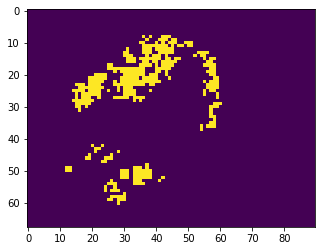

In [ ]:
slide_path = "slides/tumor_110.tif"
model = models.load_model("model_multiple_zoom")

# predition mode, 'single' if single input model
# 'multi' if multi-inputs model
pred_mode="multi"
# best results when level = 2,
# but takes much more time and sometimes crashes in colab
# so level = 3 is recommended. 
# level 4 or even lower levels can not perform well 
level = 3  

produce_heatmap_with_slide(slide_path, model, level=level, pred_mode=pred_mode)